Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

184/184 [==============================] - 110s 590ms/step - loss: 0.0112 - accuracy: 0.9988 - val_loss: 0.3374 - val_accuracy: 0.9316
Epoch 2/20
184/184 [==============================] - 107s 580ms/step - loss: 0.0134 - accuracy: 0.9972 - val_loss: 0.3307 - val_accuracy: 0.9322
Epoch 3/20
184/184 [==============================] - 105s 572ms/step - loss: 0.0111 - accuracy: 0.9979 - val_loss: 0.3296 - val_accuracy: 0.9336
Epoch 4/20
184/184 [==============================] - 107s 580ms/step - loss: 0.0125 - accuracy: 0.9983 - val_loss: 0.3303 - val_accuracy: 0.9322
Epoch 5/20
184/184 [==============================] - 107s 580ms/step - loss: 0.0106 - accuracy: 0.9991 - val_loss: 0.3281 - val_accuracy: 0.9309
Epoch 6/20
184/184 [==============================] - 107s 583ms/step - loss: 0.0156 - accuracy: 0.9972 - val_loss: 0.3357 - val_accuracy: 0.9302
Epoch 7/20
184/184 [==============================] - 110s 600ms/step - loss: 0.0111 - accuracy: 0.9985 - val_loss: 0.3364 - val_accura

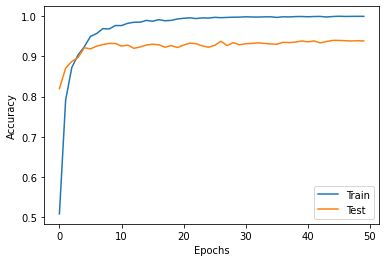

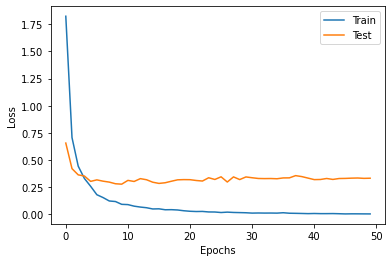

<AxesSubplot:>

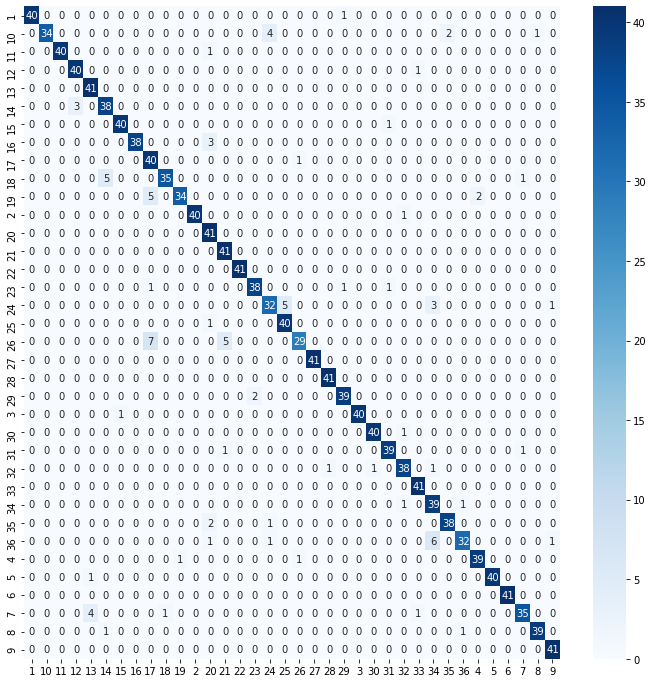

In [1]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    subset='validation',
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9425558196705462
recall_score   :  0.9383468834688347
f1_score       :  0.938019684443814
accuracy_score :  0.9383468834688347

Best accuracy  :  0.9397019147872925


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 112s 600ms/step - loss: 0.0141 - accuracy: 0.9966 - val_loss: 0.3238 - val_accuracy: 0.9309
Epoch 2/20
184/184 [==============================] - 117s 636ms/step - loss: 0.0147 - accuracy: 0.9973 - val_loss: 0.3228 - val_accuracy: 0.9316
Epoch 3/20
184/184 [==============================] - 124s 672ms/step - loss: 0.0153 - accuracy: 0.9978 - val_loss: 0.3210 - val_accuracy: 0.9316
Epoch 4/20
184/184 [==============================] - 132s 715ms/step - loss: 0.0128 - accuracy: 0.9975 - val_loss: 0.3234 - val_accuracy: 0.9329
Epoch 5/20
184/184 [==============================] - 122s 660ms/step - loss: 0.0164 - accuracy: 0.9963 - val_loss: 0.3232 - val_accuracy: 0.9336
Epoch 6/20
184/184 [==============================] - 114s 621ms/step - loss: 0.0121 - accuracy: 0.9986 - val_loss: 0.3244 - val_accuracy: 0.9350
Epoch 7/20
184/184 [==============================] - 114s 622ms/step - loss: 0.0110 - accuracy: 0.9978 - val_loss: 0.3325 - val_accura

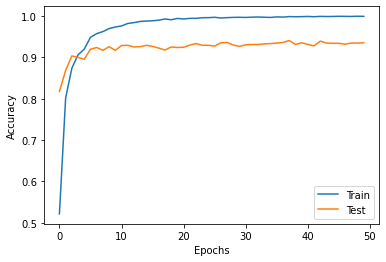

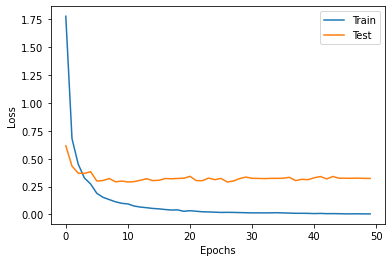

<AxesSubplot:>

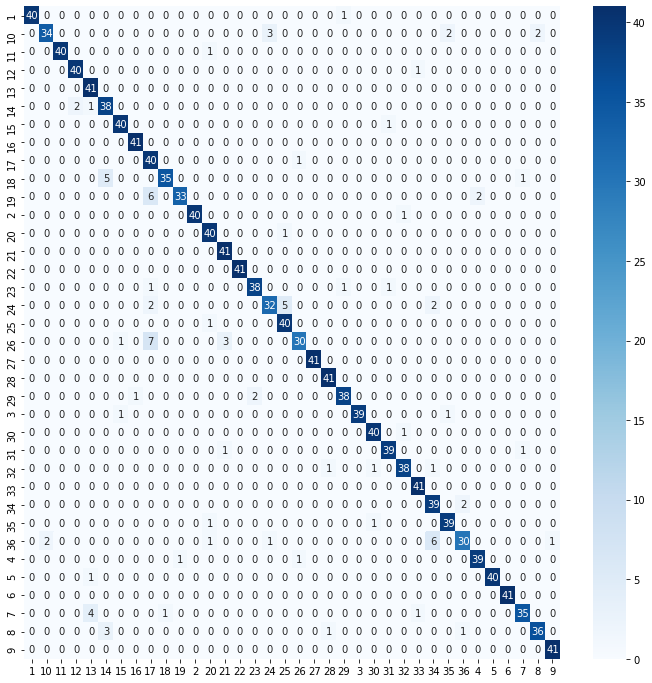

In [3]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    subset='validation',
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [4]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9396816779873163
recall_score   :  0.9356368563685636
f1_score       :  0.9352263269806568
accuracy_score :  0.9356368563685636

Best accuracy  :  0.9410569071769714


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 161s 863ms/step - loss: 0.0148 - accuracy: 0.9972 - val_loss: 0.2746 - val_accuracy: 0.9302
Epoch 2/20
184/184 [==============================] - 146s 794ms/step - loss: 0.0128 - accuracy: 0.9972 - val_loss: 0.2717 - val_accuracy: 0.9309
Epoch 3/20
184/184 [==============================] - 147s 798ms/step - loss: 0.0118 - accuracy: 0.9982 - val_loss: 0.2728 - val_accuracy: 0.9316
Epoch 4/20
184/184 [==============================] - 141s 768ms/step - loss: 0.0116 - accuracy: 0.9980 - val_loss: 0.2688 - val_accuracy: 0.9309
Epoch 5/20
184/184 [==============================] - 152s 824ms/step - loss: 0.0129 - accuracy: 0.9973 - val_loss: 0.2704 - val_accuracy: 0.9302
Epoch 6/20
184/184 [==============================] - 157s 854ms/step - loss: 0.0121 - accuracy: 0.9985 - val_loss: 0.2700 - val_accuracy: 0.9350
Epoch 7/20
184/184 [==============================] - 168s 914ms/step - loss: 0.0120 - accuracy: 0.9984 - val_loss: 0.2535 - val_accura

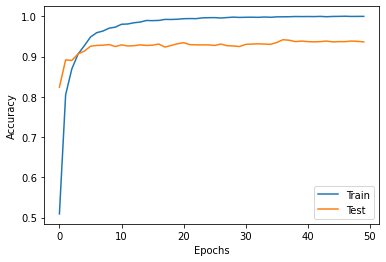

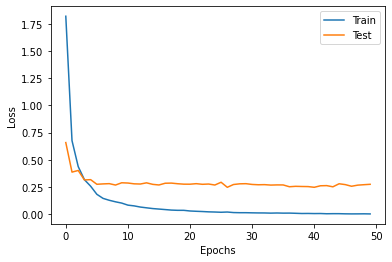

<AxesSubplot:>

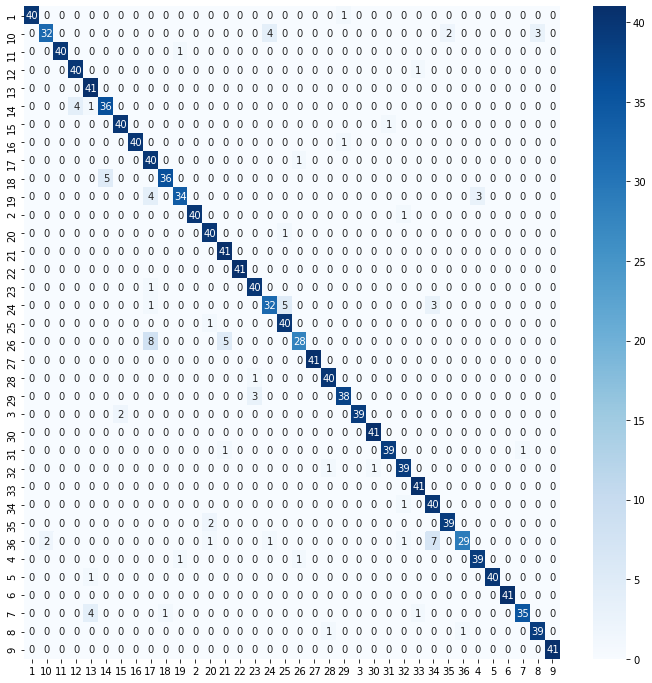

In [5]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    subset='validation',
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [6]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9403434400834433
recall_score   :  0.9363143631436314
f1_score       :  0.9354889311183813
accuracy_score :  0.9363143631436315

Best accuracy  :  0.9417344331741333


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 142s 767ms/step - loss: 0.0126 - accuracy: 0.9984 - val_loss: 0.3550 - val_accuracy: 0.9302
Epoch 2/20
184/184 [==============================] - 142s 768ms/step - loss: 0.0134 - accuracy: 0.9977 - val_loss: 0.3572 - val_accuracy: 0.9302
Epoch 3/20
184/184 [==============================] - 128s 694ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.3529 - val_accuracy: 0.9309
Epoch 4/20
184/184 [==============================] - 120s 652ms/step - loss: 0.0121 - accuracy: 0.9989 - val_loss: 0.3513 - val_accuracy: 0.9302
Epoch 5/20
184/184 [==============================] - 117s 634ms/step - loss: 0.0157 - accuracy: 0.9980 - val_loss: 0.3559 - val_accuracy: 0.9302
Epoch 6/20
184/184 [==============================] - 114s 620ms/step - loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.3427 - val_accuracy: 0.9363
Epoch 7/20
184/184 [==============================] - 110s 598ms/step - loss: 0.0102 - accuracy: 0.9983 - val_loss: 0.3601 - val_accura

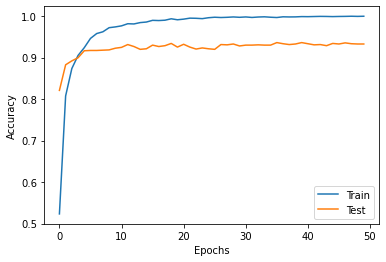

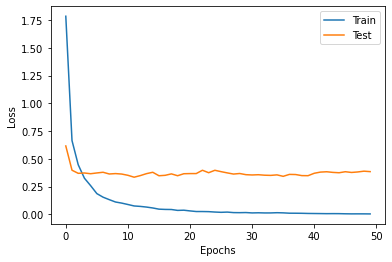

<AxesSubplot:>

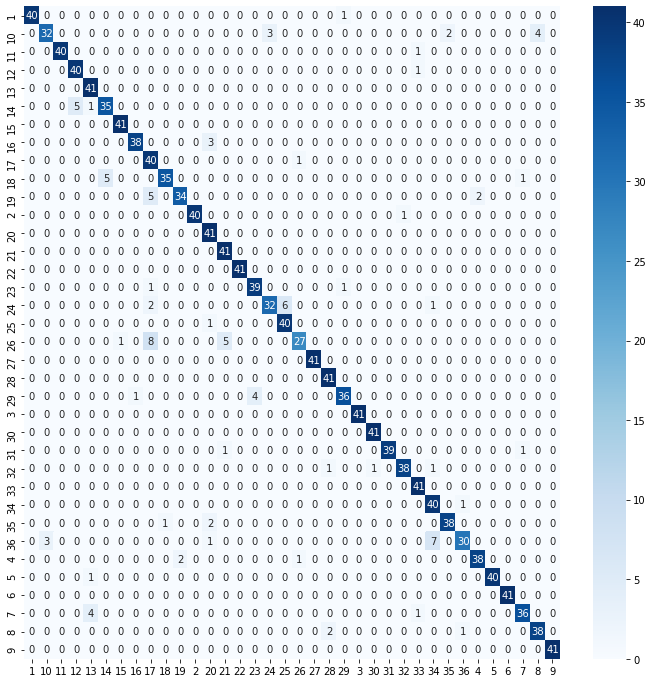

In [7]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    subset='validation',
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [8]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9374415889637179
recall_score   :  0.9329268292682927
f1_score       :  0.9321346004034624
accuracy_score :  0.9329268292682927

Best accuracy  :  0.9363143444061279


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 110s 592ms/step - loss: 0.0156 - accuracy: 0.9959 - val_loss: 0.2962 - val_accuracy: 0.9282
Epoch 2/20
184/184 [==============================] - 108s 589ms/step - loss: 0.0133 - accuracy: 0.9977 - val_loss: 0.2943 - val_accuracy: 0.9295
Epoch 3/20
184/184 [==============================] - 109s 593ms/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.2928 - val_accuracy: 0.9309
Epoch 4/20
184/184 [==============================] - 109s 593ms/step - loss: 0.0126 - accuracy: 0.9988 - val_loss: 0.2933 - val_accuracy: 0.9316
Epoch 5/20
184/184 [==============================] - 111s 601ms/step - loss: 0.0150 - accuracy: 0.9978 - val_loss: 0.2928 - val_accuracy: 0.9302
Epoch 6/20
184/184 [==============================] - 109s 593ms/step - loss: 0.0123 - accuracy: 0.9994 - val_loss: 0.2892 - val_accuracy: 0.9316
Epoch 7/20
184/184 [==============================] - 109s 595ms/step - loss: 0.0125 - accuracy: 0.9981 - val_loss: 0.2772 - val_accura

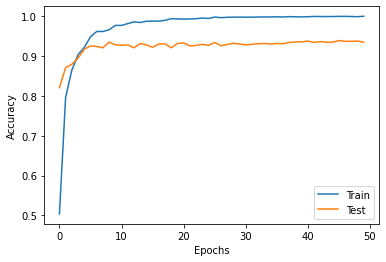

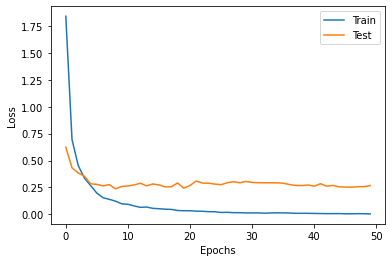

<AxesSubplot:>

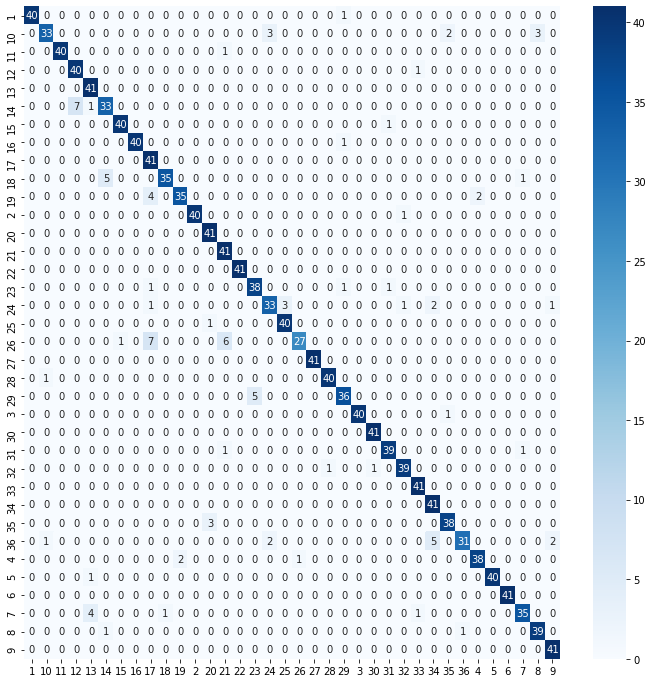

In [9]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 30
epochs2 = 20
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned20

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    subset='validation',
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [10]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9388012369798974
recall_score   :  0.9349593495934959
f1_score       :  0.9340333538048087
accuracy_score :  0.9349593495934959

Best accuracy  :  0.9390243887901306


Populating the interactive namespace from numpy and matplotlib
21 0
Predicted class: 29  actual class: 1/002_06.jpg 1


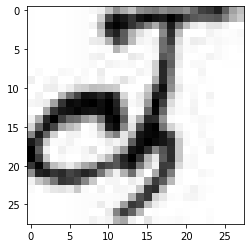

34 1
Predicted class: 8  actual class: 10/001_03.jpg 10


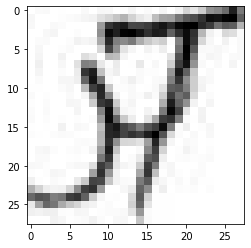

34 1
Predicted class: 8  actual class: 10/001_09.jpg 10


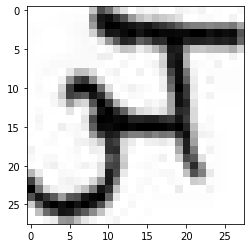

34 1
Predicted class: 8  actual class: 10/001_10.jpg 10


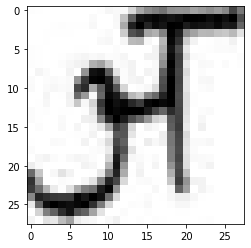

16 1
Predicted class: 24  actual class: 10/002_04.jpg 10


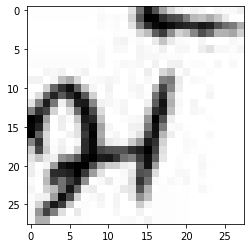

28 1
Predicted class: 35  actual class: 10/002_05.jpg 10


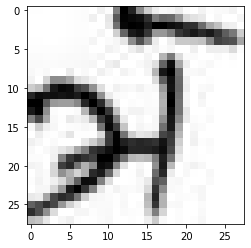

16 1
Predicted class: 24  actual class: 10/002_06.jpg 10


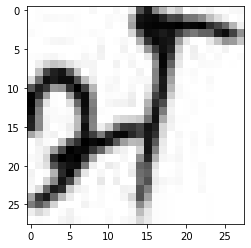

16 1
Predicted class: 24  actual class: 10/002_07.jpg 10


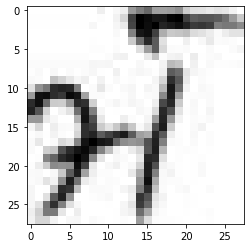

28 1
Predicted class: 35  actual class: 10/002_11.jpg 10


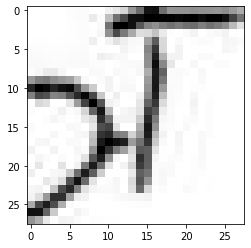

13 2
Predicted class: 21  actual class: 11/002_04.jpg 11


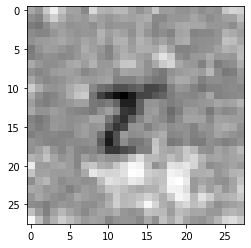

26 3
Predicted class: 33  actual class: 12/002_08.jpg 12


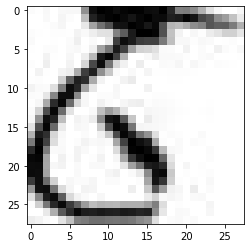

3 5
Predicted class: 12  actual class: 14/001_13.jpg 14


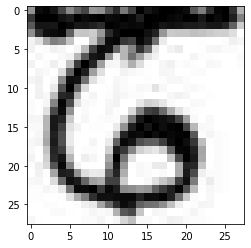

3 5
Predicted class: 12  actual class: 14/001_16.jpg 14


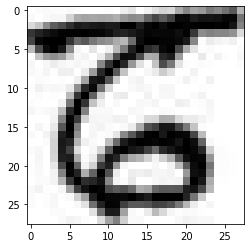

3 5
Predicted class: 12  actual class: 14/001_17.jpg 14


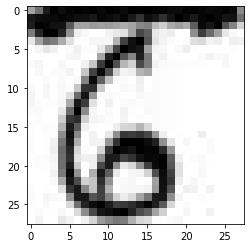

4 5
Predicted class: 13  actual class: 14/002_04.jpg 14


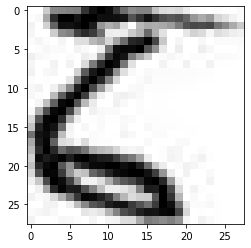

3 5
Predicted class: 12  actual class: 14/002_05.jpg 14


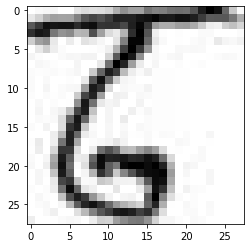

3 5
Predicted class: 12  actual class: 14/002_07.jpg 14


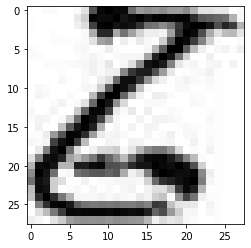

3 5
Predicted class: 12  actual class: 14/002_11.jpg 14


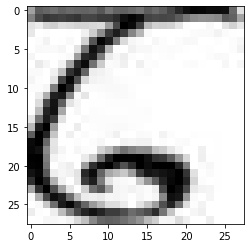

3 5
Predicted class: 12  actual class: 14/004_01.jpg 14


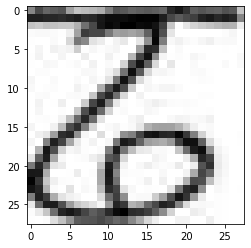

24 6
Predicted class: 31  actual class: 15/002_05.jpg 15


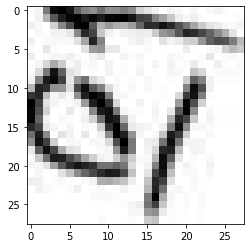

21 7
Predicted class: 29  actual class: 16/002_13.jpg 16


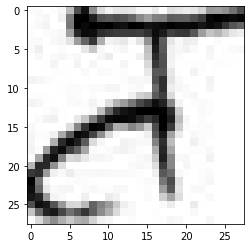

33 9
Predicted class: 7  actual class: 18/002_06.jpg 18


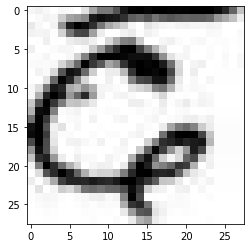

5 9
Predicted class: 14  actual class: 18/004_02.jpg 18


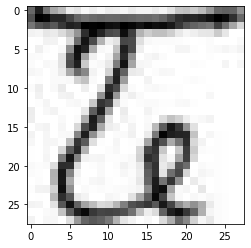

5 9
Predicted class: 14  actual class: 18/004_06.jpg 18


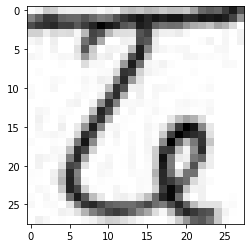

5 9
Predicted class: 14  actual class: 18/004_07.jpg 18


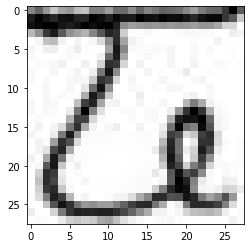

5 9
Predicted class: 14  actual class: 18/004_09.jpg 18


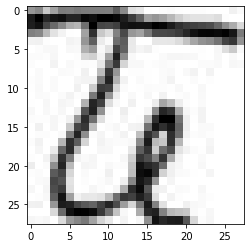

5 9
Predicted class: 14  actual class: 18/004_11.jpg 18


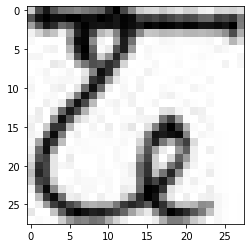

8 10
Predicted class: 17  actual class: 19/001_01.jpg 19


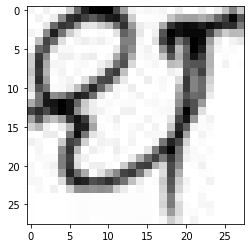

8 10
Predicted class: 17  actual class: 19/001_06.jpg 19


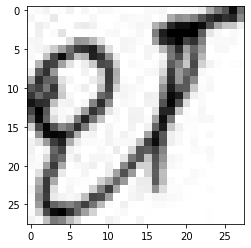

8 10
Predicted class: 17  actual class: 19/004_04.jpg 19


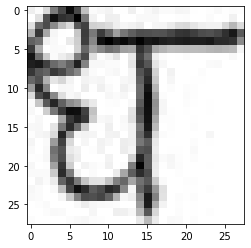

30 10
Predicted class: 4  actual class: 19/004_05.jpg 19


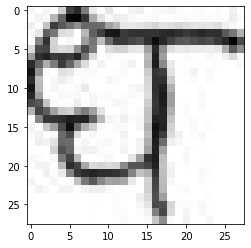

8 10
Predicted class: 17  actual class: 19/004_06.jpg 19


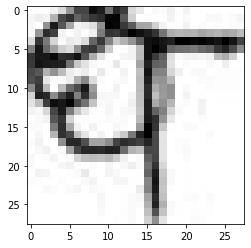

30 10
Predicted class: 4  actual class: 19/004_08.jpg 19


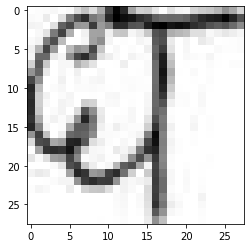

25 11
Predicted class: 32  actual class: 2/001_16.jpg 2


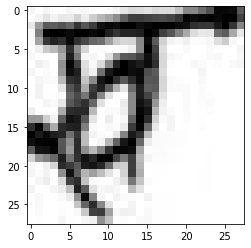

24 15
Predicted class: 31  actual class: 23/001_04.jpg 23


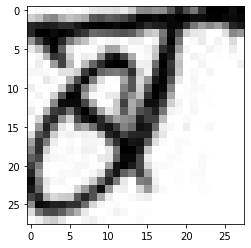

8 15
Predicted class: 17  actual class: 23/004_03.jpg 23


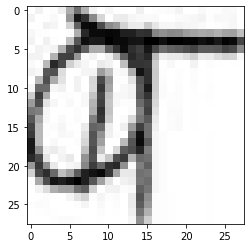

21 15
Predicted class: 29  actual class: 23/004_10.jpg 23


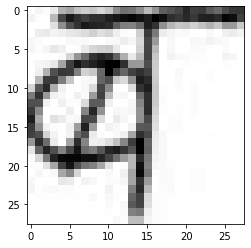

27 16
Predicted class: 34  actual class: 24/004_01.jpg 24


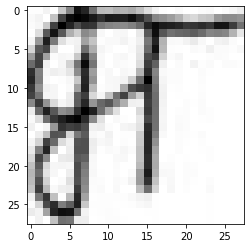

35 16
Predicted class: 9  actual class: 24/004_03.jpg 24


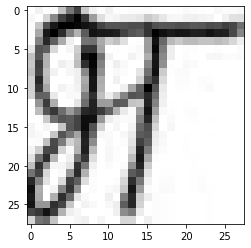

8 16
Predicted class: 17  actual class: 24/004_04.jpg 24


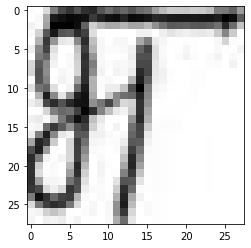

27 16
Predicted class: 34  actual class: 24/004_05.jpg 24


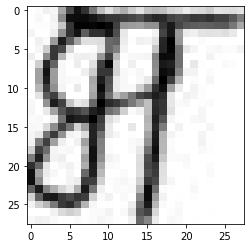

17 16
Predicted class: 25  actual class: 24/004_07.jpg 24


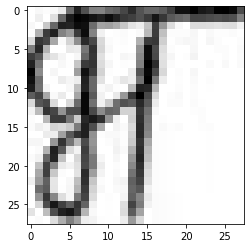

17 16
Predicted class: 25  actual class: 24/004_08.jpg 24


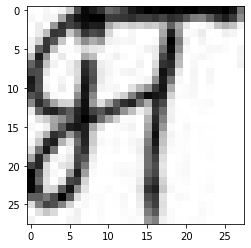

17 16
Predicted class: 25  actual class: 24/004_09.jpg 24


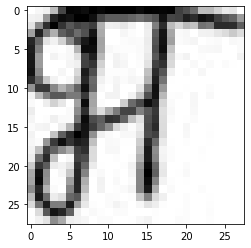

25 16
Predicted class: 32  actual class: 24/004_10.jpg 24


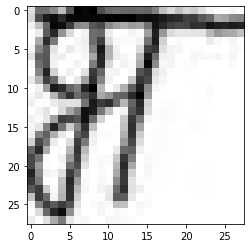

12 17
Predicted class: 20  actual class: 25/001_07.jpg 25


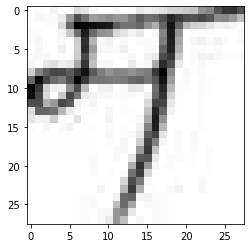

8 18
Predicted class: 17  actual class: 26/001_01.jpg 26


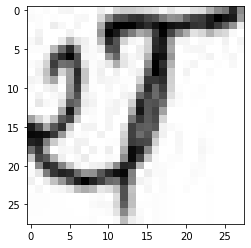

8 18
Predicted class: 17  actual class: 26/001_05.jpg 26


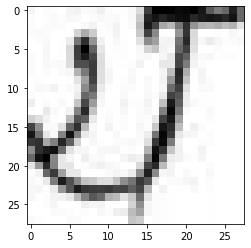

8 18
Predicted class: 17  actual class: 26/001_17.jpg 26


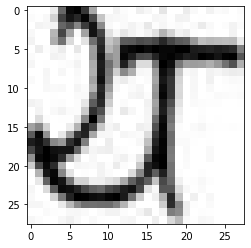

13 18
Predicted class: 21  actual class: 26/002_07.jpg 26


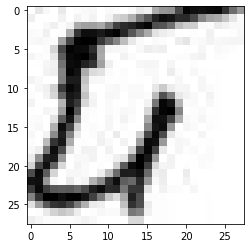

13 18
Predicted class: 21  actual class: 26/004_01.jpg 26


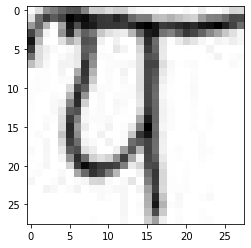

13 18
Predicted class: 21  actual class: 26/004_02.jpg 26


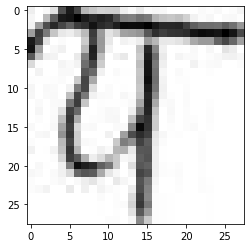

8 18
Predicted class: 17  actual class: 26/004_03.jpg 26


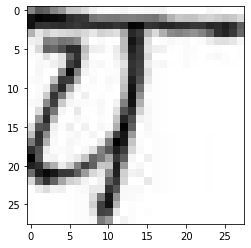

13 18
Predicted class: 21  actual class: 26/004_05.jpg 26


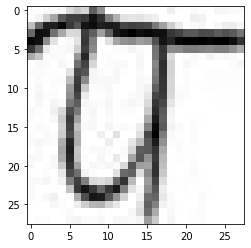

13 18
Predicted class: 21  actual class: 26/004_06.jpg 26


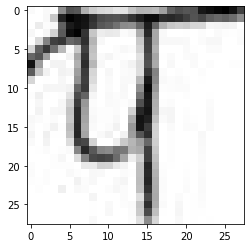

8 18
Predicted class: 17  actual class: 26/004_07.jpg 26


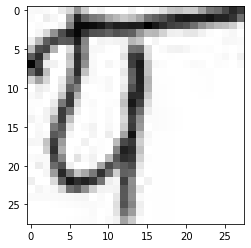

6 18
Predicted class: 15  actual class: 26/004_08.jpg 26


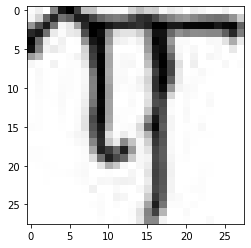

8 18
Predicted class: 17  actual class: 26/004_09.jpg 26


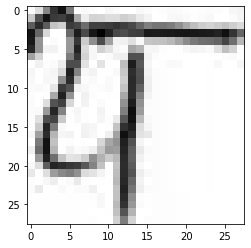

13 18
Predicted class: 21  actual class: 26/004_10.jpg 26


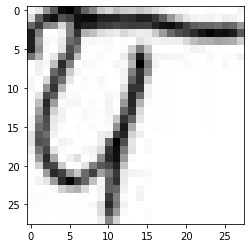

8 18
Predicted class: 17  actual class: 26/004_11.jpg 26


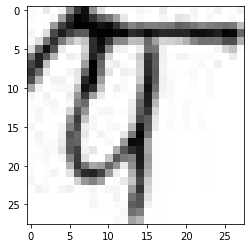

1 20
Predicted class: 10  actual class: 28/001_08.jpg 28


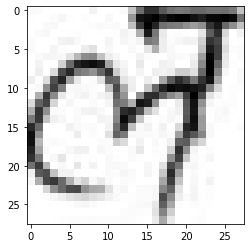

15 21
Predicted class: 23  actual class: 29/001_10.jpg 29


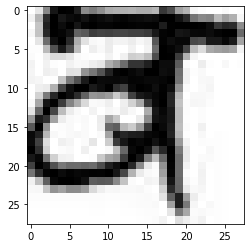

15 21
Predicted class: 23  actual class: 29/002_01.jpg 29


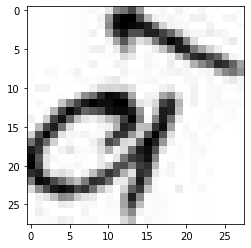

15 21
Predicted class: 23  actual class: 29/002_03.jpg 29


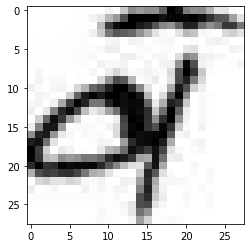

15 21
Predicted class: 23  actual class: 29/002_09.jpg 29


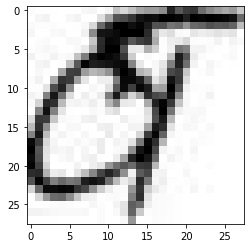

15 21
Predicted class: 23  actual class: 29/002_12.jpg 29


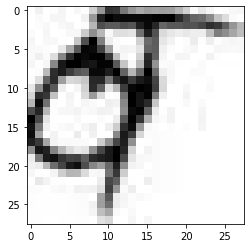

28 22
Predicted class: 35  actual class: 3/002_05.jpg 3


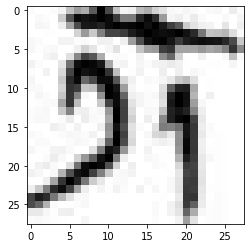

33 24
Predicted class: 7  actual class: 31/002_06.jpg 31


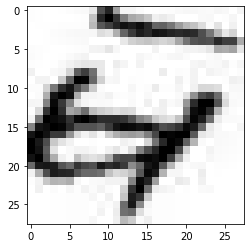

13 24
Predicted class: 21  actual class: 31/004_06.jpg 31


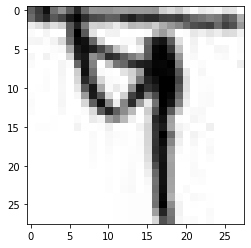

20 25
Predicted class: 28  actual class: 32/002_02.jpg 32


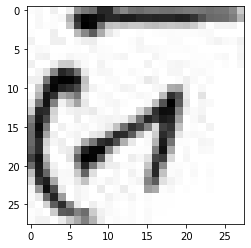

23 25
Predicted class: 30  actual class: 32/002_03.jpg 32


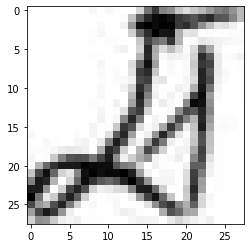

12 28
Predicted class: 20  actual class: 35/001_04.jpg 35


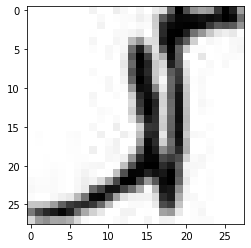

12 28
Predicted class: 20  actual class: 35/001_07.jpg 35


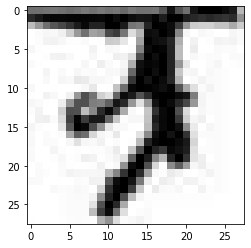

12 28
Predicted class: 20  actual class: 35/002_13.jpg 35


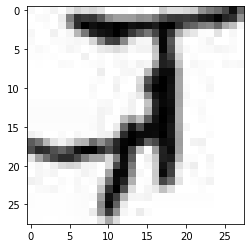

27 29
Predicted class: 34  actual class: 36/001_01.jpg 36


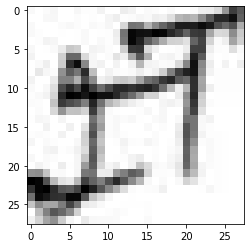

27 29
Predicted class: 34  actual class: 36/001_02.jpg 36


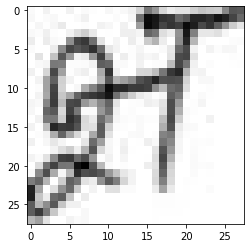

27 29
Predicted class: 34  actual class: 36/001_03.jpg 36


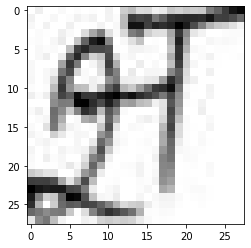

16 29
Predicted class: 24  actual class: 36/001_04.jpg 36


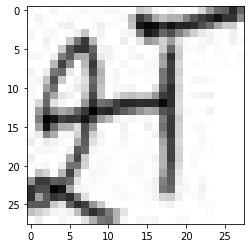

27 29
Predicted class: 34  actual class: 36/001_07.jpg 36


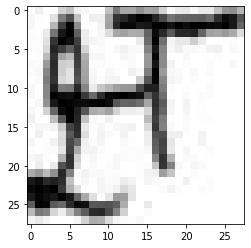

1 29
Predicted class: 10  actual class: 36/001_08.jpg 36


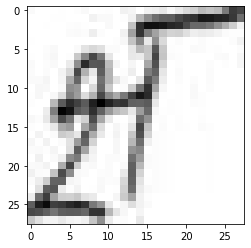

35 29
Predicted class: 9  actual class: 36/001_09.jpg 36


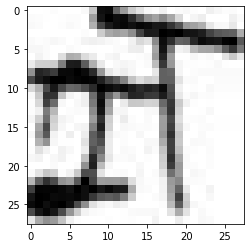

16 29
Predicted class: 24  actual class: 36/001_11.jpg 36


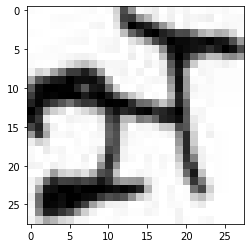

27 29
Predicted class: 34  actual class: 36/001_15.jpg 36


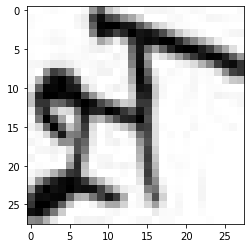

35 29
Predicted class: 9  actual class: 36/002_10.jpg 36


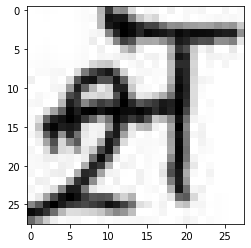

10 30
Predicted class: 19  actual class: 4/002_05.jpg 4


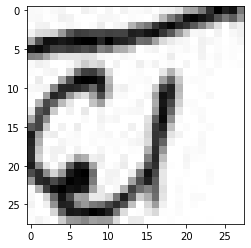

10 30
Predicted class: 19  actual class: 4/002_06.jpg 4


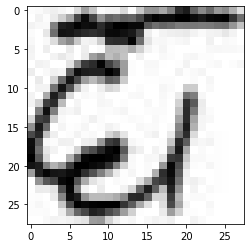

18 30
Predicted class: 26  actual class: 4/002_11.jpg 4


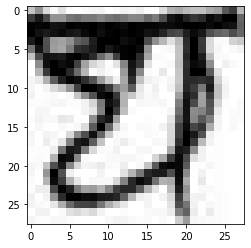

4 31
Predicted class: 13  actual class: 5/002_02.jpg 5


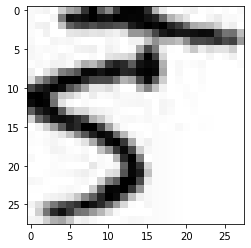

9 33
Predicted class: 18  actual class: 7/001_01.jpg 7


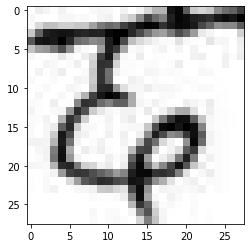

4 33
Predicted class: 13  actual class: 7/002_04.jpg 7


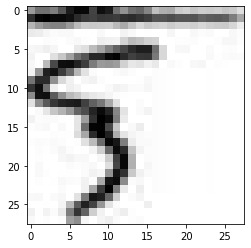

4 33
Predicted class: 13  actual class: 7/002_06.jpg 7


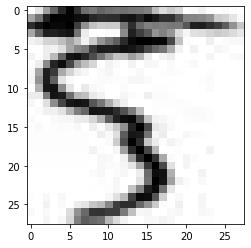

4 33
Predicted class: 13  actual class: 7/002_07.jpg 7


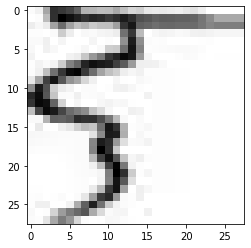

4 33
Predicted class: 13  actual class: 7/002_08.jpg 7


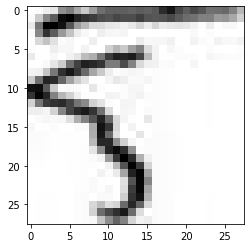

26 33
Predicted class: 33  actual class: 7/002_13.jpg 7


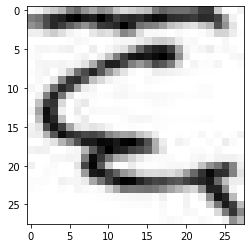

5 34
Predicted class: 14  actual class: 8/002_08.jpg 8


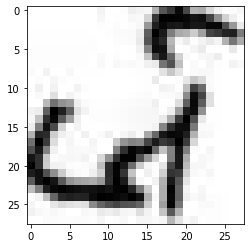

29 34
Predicted class: 36  actual class: 8/004_06.jpg 8


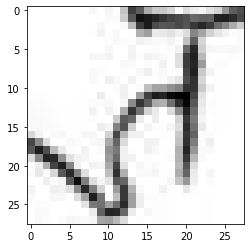

In [12]:
# miss-classification analysis
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_folder = './Data/Offline/NHCD/consonants/'

image_names = validation_generator.filenames
image_classes = validation_generator.classes
class_dict = validation_generator.class_indices
class_dict = dict((v,k) for k,v in class_dict.items())

image_predicted = y_pred

for i in range(len(image_predicted)):
    if image_predicted[i] != image_classes[i]:
        print(image_predicted[i], image_classes[i])
        print('Predicted class:', class_dict[image_predicted[i]], ' actual class:', image_names[i], class_dict[image_classes[i]])
        img = mpimg.imread(test_folder + image_names[i])
        imgplot = plt.imshow(img, cmap='gray')
        plt.show()
#         break;